In [835]:
# Libraries
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import pickle
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from dotenv import load_dotenv
from supabase import create_client
import os

In [836]:
# Read data
load_dotenv()

SUPABASE_URL = os.getenv("NEXT_PUBLIC_SUPABASE_URL")
SUPABASE_SERVICE_KEY = os.getenv("NEXT_PUBLIC_SUPABASE_SERVICE_KEY")

supabase = create_client(SUPABASE_URL, SUPABASE_SERVICE_KEY)

MAKE = "Ferrari"
min_observations = 10

response = (
    supabase.table("bat_completed_auctions")
    .select("year, model, mileage, normalized_color, transmission, sold_price, bid_amount, end_date, status")
    .eq("make", MAKE)
    .eq("country_code", "US")
    .not_.is_("model", None)
    .not_.is_("mileage", None)
    .not_.is_("transmission", None)
    .not_.is_("normalized_color", None)
    .not_.is_("year", None)
    .execute()
)
df = pd.DataFrame(response.data)

In [837]:
# Count by model
counts = df[['model','status']].groupby('model').count().sort_values(by='status',ascending=False)
print(counts)

                                    status
model                                     
Testarossa                             184
328 GTS                                162
F355 Spider 6-Speed                    150
550 Maranello                          123
F430 Spider                             98
...                                    ...
456M GT Schumacher Edition 6-Speed       1
458 Challenge Evo                        1
458 Speciale Aperta                      1
488 Challenge EVO Race Car               1
na 312T2 Children’s Car                  1

[273 rows x 1 columns]


In [838]:
# Price by model
display_p=df[['model','year','sold_price']]

fig=px.box(display_p,x="model",y="sold_price")
fig.update_layout(title_text='Price vs Model',xaxis_title="Model",yaxis_title="Average Price")

In [839]:
# Filter to models with more than min_observations
counts=df['model'].value_counts()
frequent_models = counts[counts >= min_observations].index

# Filter the data to frequent models
df = df[df['model'].isin(frequent_models)]
popular_labels=frequent_models

colors=['lightslategray',]*len(popular_labels)
colors[0]='crimson'

fig=go.Figure(data=[go.Bar(x=counts[:25],y=popular_labels,marker_color=colors,orientation='h')])
fig.update_layout(title_text='Most represented Models in the Dataset',xaxis_title="Count",yaxis_title="Model")

In [840]:
#distribution of number of cars over the years
dic = {1970+i : sum(df['year']==1970+i) for i in range(55)}
x_dic = [1970 + i for i in range(55)]
y_dic = [dic[1970 + i] for i in range(55)]

# Plot
fig = go.Figure([go.Bar(x=x_dic, y=y_dic)])

fig.update_layout(title="Car year distribution",
                  xaxis_title="Year",
                  yaxis_title="Count Cars sold")


fig.show()

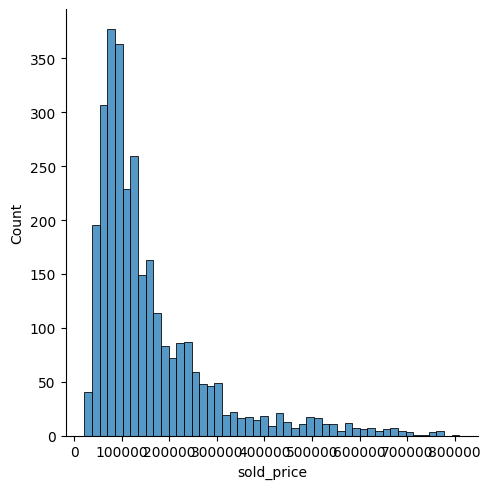

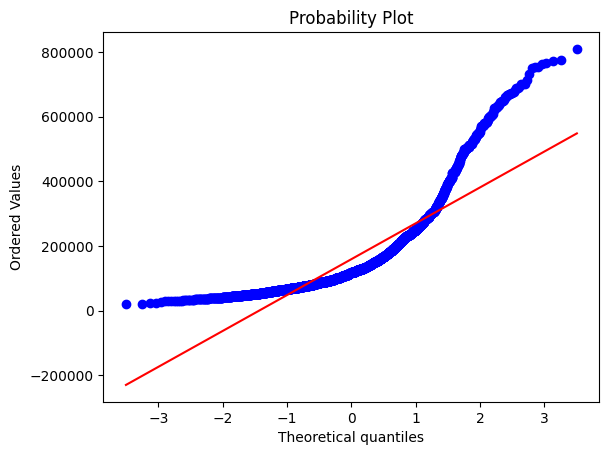

In [841]:
# Replace sold_price with bid_amount and remove outliers
df['sold_price'] = df['sold_price'].fillna(df['bid_amount'])
df = df.dropna()

# Remove outliers
price_threshold = 1000000
df.drop(df[df['sold_price'] >= price_threshold].index,inplace=True)

# Plot distribution of sold_price
sns.displot(df['sold_price'])
fig = plt.figure()
res = stats.probplot(df['sold_price'], plot=plt)


array([[<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'mileage'}>],
       [<Axes: title={'center': 'sold_price'}>,
        <Axes: title={'center': 'bid_amount'}>]], dtype=object)

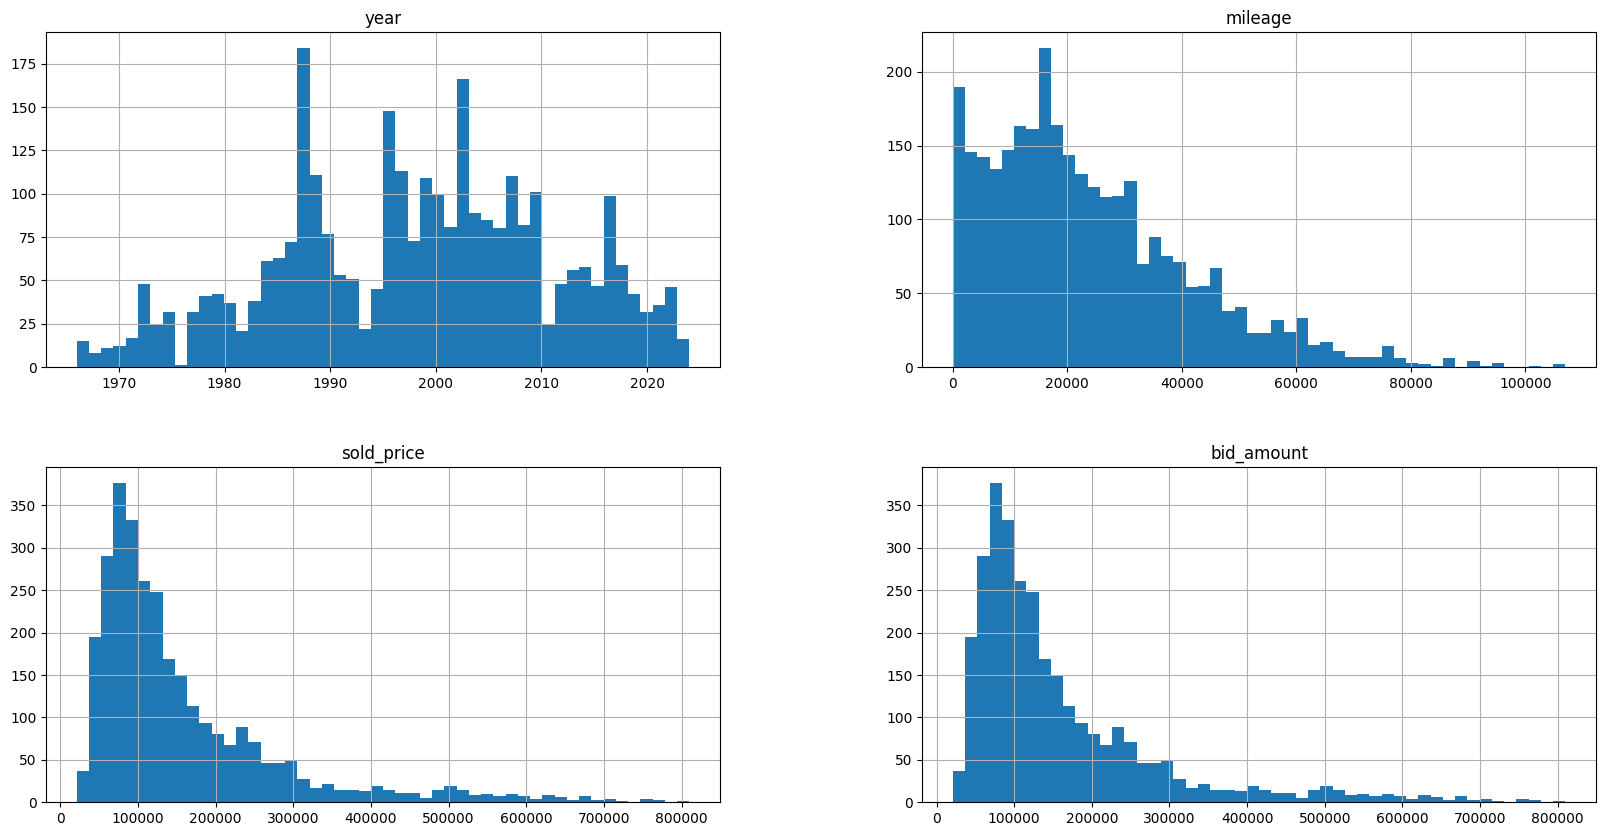

In [842]:
# Data distribution
df.hist(figsize=(20,10),bins = 50)

In [843]:
# Weight by recency
df['days_since_end'] = (pd.to_datetime(date.today()) - pd.to_datetime(df["end_date"])).dt.days
K = 1
T = 360
df['W'] = K*np.exp(-df['days_since_end']/T)


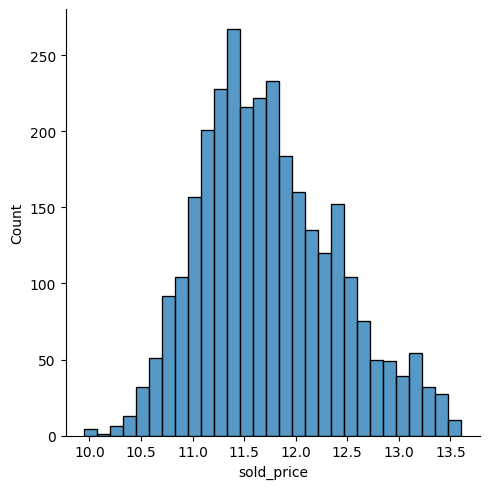

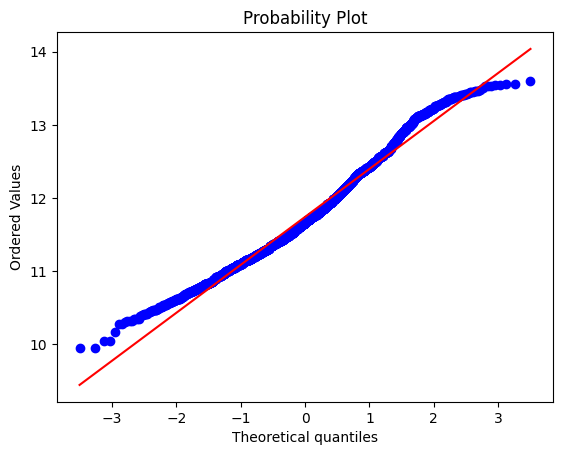

In [844]:
#Log transform sold_price & mileage
df['sold_price'] = np.log(df['sold_price'])
df['mileage'] = np.log1p(df['mileage'])

sns.displot(df['sold_price'])
fig = plt.figure()
res = stats.probplot(df['sold_price'], plot=plt)

In [845]:
# Summarize transformed data
df.describe()

,year,mileage,sold_price,bid_amount,days_since_end,W
count,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000
mean,1998.232604,9.670823,11.742645,159204.736249,946.787939,0.211713
std,13.022643,1.137252,0.660512,126224.302051,676.605085,0.244246
min,1966.000000,0.000000,9.952278,21000.000000,1.000000,0.000105
25%,1988.000000,9.210440,11.258033,77500.000000,399.000000,0.021849
50%,1999.000000,9.903538,11.669929,117000.000000,806.000000,0.106577
75%,2007.000000,10.434145,12.175291,193937.500000,1376.500000,0.330109
max,2024.000000,11.580593,13.604790,810000.000000,3299.000000,0.997226


In [846]:
# Prepare target and features
y = df["sold_price"]
X = df.drop(["sold_price","bid_amount","end_date", "status", "days_since_end"],axis=1)
X

,year,model,mileage,normalized_color,transmission,W
0,2022,F8 Spider,7.937732,White,automatic,0.997226
1,1985,Mondial Quattrovalvole Cabriolet,10.518700,Gold,manual,0.997226
2,2019,488 Spider,9.305741,Black,automatic,0.997226
3,2012,California,9.998843,Gray,automatic,0.994460
4,2016,488 GTB,10.463132,Black,automatic,0.994460
...,...,...,...,...,...,...
3450,1988,Testarossa,10.275086,Black,manual,0.000190
3451,1995,F355 Spider 6-Speed,9.842250,Red,manual,0.000174
3452,1989,328 GTB,10.950824,Red,manual,0.000168
3453,1997,F355 Spider 6-Speed,9.367430,Red,automatic,0.000162


In [847]:
# Encode categorical features
Lbl_model = LabelEncoder()
Lbl_color = LabelEncoder()
Lbl_trans = LabelEncoder()

#df.make=Lbl.fit_transform(df.make)
X.model=Lbl_model.fit_transform(df.model)
print("Model Mapping:", dict(zip(Lbl_model.classes_, Lbl_model.transform(Lbl_model.classes_))))
X.normalized_color=Lbl_color.fit_transform(df.normalized_color)
print("Color Mapping:", dict(zip(Lbl_color.classes_, Lbl_color.transform(Lbl_color.classes_))))
X.transmission =Lbl_trans.fit_transform(df.transmission)
print("Trans Mapping:", dict(zip(Lbl_trans.classes_, Lbl_trans.transform(Lbl_trans.classes_))))
X

Model Mapping: {'308 GT4': 0, '308 GTB': 1, '308 GTS': 2, '308 GTS Quattrovalvole': 3, '308 GTSi': 4, '308 GTSi Quattrovalvole': 5, '328 GTB': 6, '328 GTS': 7, '330 GTC': 8, '348 Spider': 9, '348 TB': 10, '348 TS': 11, '360 Challenge Stradale': 12, '360 Modena': 13, '360 Modena 6-Speed': 14, '360 Spider': 15, '360 Spider 6-Speed': 16, '365 GT 2+2': 17, '365 GTB/4 Daytona Berlinetta': 18, '365 GTC/4': 19, '400i': 20, '430 Scuderia': 21, '430 Scuderia Spider 16M': 22, '456 GT 6-Speed': 23, '456 GTA': 24, '456M GT 6-Speed': 25, '456M GTA': 26, '458 Italia': 27, '458 Speciale': 28, '458 Spider': 29, '488 GTB': 30, '488 Pista': 31, '488 Spider': 32, '512 BB': 33, '512 BBi': 34, '512 TR': 35, '550 Maranello': 36, '575 Superamerica GTC': 37, '575M Maranello': 38, '575M Maranello 6-Speed': 39, '599 GTB Fiorano': 40, '599 GTB Fiorano HGTE': 41, '612 Scaglietti': 42, '812 GTS': 43, '812 Superfast': 44, 'California': 45, 'California T': 46, 'Dino 246 GT': 47, 'Dino 246 GTS': 48, 'Dino 308 GT4': 4

,year,model,mileage,normalized_color,transmission,W
0,2022,63,7.937732,17,0,0.997226
1,1985,69,10.518700,6,1,0.997226
2,2019,32,9.305741,2,0,0.997226
3,2012,45,9.998843,7,0,0.994460
4,2016,30,10.463132,2,0,0.994460
...,...,...,...,...,...,...
3450,1988,76,10.275086,2,1,0.000190
3451,1995,56,9.842250,12,1,0.000174
3452,1989,6,10.950824,12,1,0.000168
3453,1997,56,9.367430,12,0,0.000162


In [ ]:
# Fit Model
# Features
# year	model	mileage	normalized_color	transmission
X["model"]=X["model"].astype("category")
X["normalized_color"]=X["normalized_color"].astype("category")
xgb_model = XGBRegressor(random_state=42, monotone_constraints=(0,0,-1,0,0,0), enable_categorical=True, 
                         gamma = 0.001)
CV_xgb = GridSearchCV(
    xgb_model,
    {"n_estimators": [100,200,300], "max_depth": [12]},
    verbose=1,
    cv=5,
)
CV_xgb.fit(X, y, sample_weight=X['W'])
print(CV_xgb.best_params_)
print('XGB Train Score is : ', CV_xgb.score(X, y))
predicted_xg = pd.DataFrame(CV_xgb.predict(X), index=X.index, columns=['predicted_xg'])


Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'max_depth': 12, 'n_estimators': 300}
XGB Train Score is :  0.9573536102432475


In [849]:
param_grid = { 
'n_estimators': [50, 100, 150],
'criterion' :['squared_error', 'friedman_mse']
}

car_model_rf = RandomForestRegressor(random_state=33, monotonic_cst = [0,0,-1,0,0,0])
CV_rfc = GridSearchCV(estimator=car_model_rf, param_grid=param_grid, cv=5)
CV_rfc.fit(X, y, sample_weight=X['W'])
print(CV_rfc.best_params_)
print('Random Forest Regressor Train Score is : ', CV_rfc.score(X, y))
predicted_rf = pd.DataFrame(CV_rfc.predict(X), index=X.index, columns=['predicted_rf'])
 

{'criterion': 'friedman_mse', 'n_estimators': 150}
Random Forest Regressor Train Score is :  0.8640365064245565


In [850]:
# Save model and encoders
path = f"../models/{MAKE}"
if not os.path.exists(path):
    os.makedirs(path)

pickle.dump(car_model_rf, open(f'{path}/model.pkl','wb'))
pickle.dump(Lbl_model, open(f'{path}/labels_model.pkl','wb'))
pickle.dump(Lbl_color, open(f'{path}/labels_color.pkl','wb'))
pickle.dump(Lbl_trans, open(f'{path}/labels_transmission.pkl','wb'))

In [893]:
# Inverse transform features
X_analysis = X.copy()
X_analysis.model = Lbl_model.inverse_transform(X.model)
X_analysis.normalized_color = Lbl_color.inverse_transform(X.normalized_color)
X_analysis.transmission = Lbl_trans.inverse_transform(X.transmission)
X_analysis

,year,model,mileage,normalized_color,transmission,W
0,2022,F8 Spider,7.937732,White,automatic,0.997226
1,1985,Mondial Quattrovalvole Cabriolet,10.518700,Gold,manual,0.997226
2,2019,488 Spider,9.305741,Black,automatic,0.997226
3,2012,California,9.998843,Gray,automatic,0.994460
4,2016,488 GTB,10.463132,Black,automatic,0.994460
...,...,...,...,...,...,...
3450,1988,Testarossa,10.275086,Black,manual,0.000190
3451,1995,F355 Spider 6-Speed,9.842250,Red,manual,0.000174
3452,1989,328 GTB,10.950824,Red,manual,0.000168
3453,1997,F355 Spider 6-Speed,9.367430,Red,automatic,0.000162


In [894]:
# Analyze Results: Add target and predicted values
X_analysis = pd.merge(y, X_analysis, how='inner', left_index=True, right_index=True)
X_analysis = pd.merge(X_analysis, predicted_rf, how='inner', left_index=True, right_index=True)
X_analysis = pd.merge(X_analysis, predicted_xg, how='inner', left_index=True, right_index=True)
X_analysis.sold_price = np.exp(X_analysis.sold_price)
X_analysis.predicted_rf = np.exp(X_analysis.predicted_rf)
X_analysis.predicted_xg = np.exp(X_analysis.predicted_xg)
X_analysis.mileage = np.exp(X_analysis.mileage) - 1
X_analysis

,sold_price,year,model,mileage,normalized_color,transmission,W,predicted_rf,predicted_xg
0,362000.0,2022,F8 Spider,2800.0,White,automatic,0.997226,360127.658083,362215.093750
1,65500.0,1985,Mondial Quattrovalvole Cabriolet,37000.0,Gold,manual,0.997226,59680.882624,65511.070312
2,249000.0,2019,488 Spider,11000.0,Black,automatic,0.997226,224038.733850,249001.640625
3,78002.0,2012,California,22000.0,Gray,automatic,0.994460,82422.453688,78007.460938
4,182000.0,2016,488 GTB,35000.0,Black,automatic,0.994460,178691.314385,182105.406250
...,...,...,...,...,...,...,...,...,...
3450,100000.0,1988,Testarossa,29000.0,Black,manual,0.000190,109442.305499,86387.156250
3451,72500.0,1995,F355 Spider 6-Speed,18811.0,Red,manual,0.000174,102501.319329,62915.519531
3452,61000.0,1989,328 GTB,57000.0,Red,manual,0.000168,59051.136860,70609.085938
3453,83500.0,1997,F355 Spider 6-Speed,11700.0,Red,automatic,0.000162,107714.326769,64831.007812


<Axes: xlabel='sold_price', ylabel='predicted_xg'>

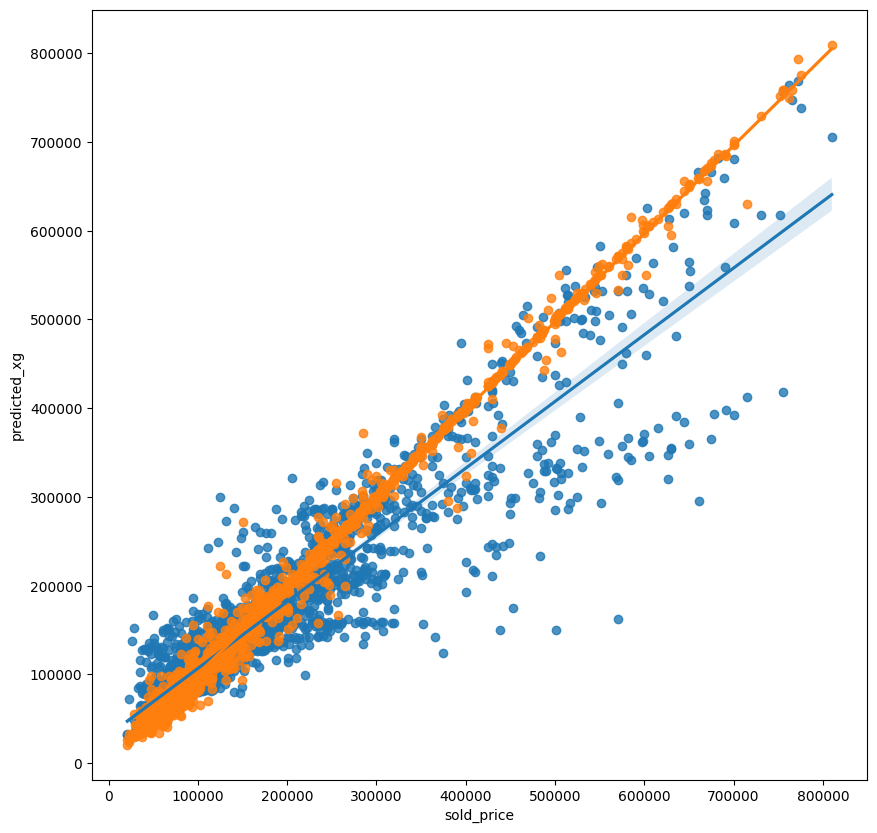

In [895]:
# Plot true vs predicted values scatter

plt.figure(figsize = (10, 10))
sns.regplot(x=X_analysis.sold_price, y=X_analysis.predicted_rf)
sns.regplot(x=X_analysis.sold_price, y=X_analysis.predicted_xg)

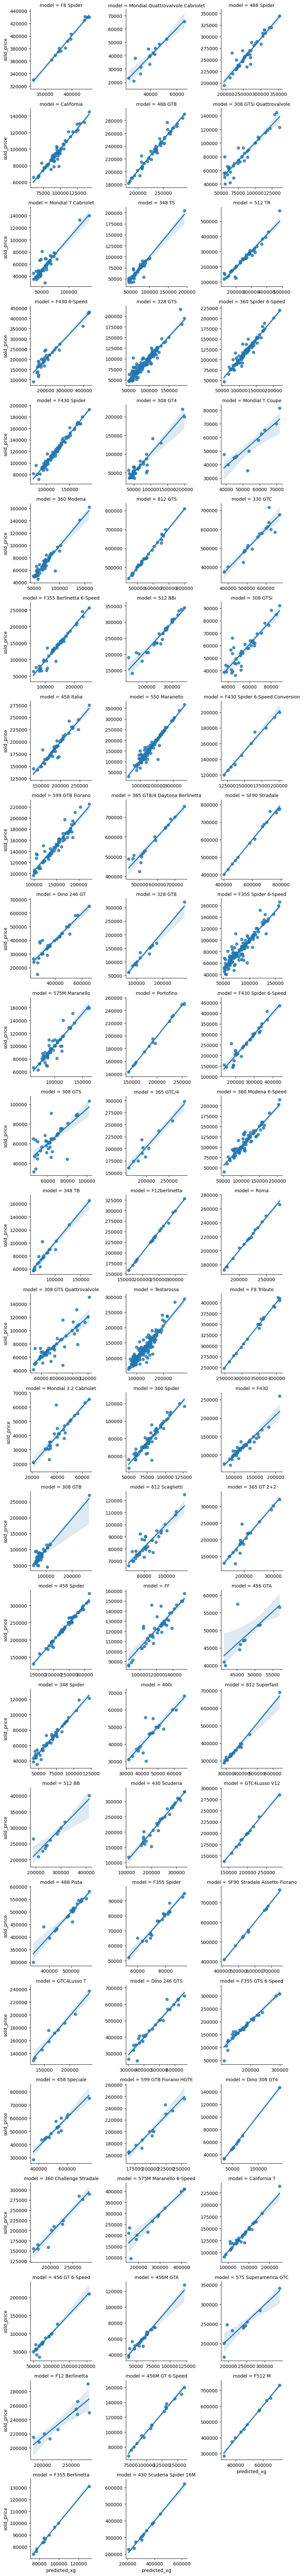

In [854]:
# Predicted vs Sold Price Scatter by model
g = sns.FacetGrid(X_analysis, col="model", col_wrap=3, sharex=False, sharey=False)

# Map scatter plots to the grid
g.map(sns.regplot, "predicted_xg", "sold_price")

In [855]:
# Prediction function

def predict(year, model, mileage, color, transmission, carmodel, W):
    input_data = pd.DataFrame([[year, model, mileage, color, transmission, W]], 
                              columns=["year", "model", "mileage", "normalized_color", "transmission", "W"])
    input_data.model=Lbl_model.transform(input_data.model)
    input_data.normalized_color=Lbl_color.transform(input_data.normalized_color)
    input_data.transmission=Lbl_trans.transform(input_data.transmission)
    input_data.mileage = np.log1p(input_data.mileage)
    price_scaled = carmodel.predict(input_data)

    price = np.exp(price_scaled)
    
    return price[0].round(0)

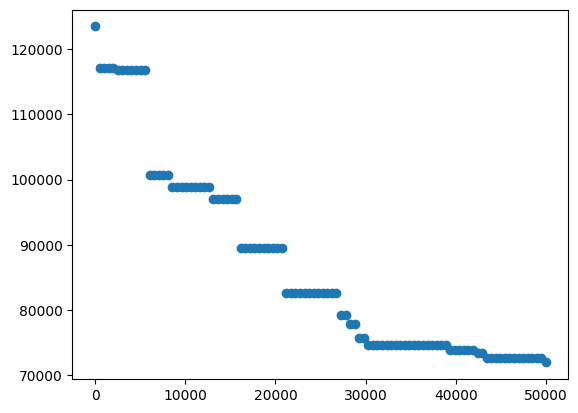

In [916]:
# Run a prediction for a car over a range of mileage
mileage_range = np.linspace(0, 50000, 100)

predictions = []
for mileage in mileage_range:
    prediction = predict(
        year = 2023,
        model = "California",
        mileage = mileage,
        color = "Black",
        transmission = "manual",
        carmodel = CV_xgb,
        W = 1
    )
    predictions.append(prediction)

predictions = pd.DataFrame(predictions, columns=["predicted"])
mileage_range = pd.DataFrame(mileage_range, columns=["mileage"])
predictions = pd.merge(predictions, mileage_range, how='inner', left_index=True, right_index=True)
plt.scatter(predictions["mileage"], predictions["predicted"])